In [1]:
# %load_ext autoreload
# %autoreload 2

import os
import torch
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave

import warnings
warnings.filterwarnings('ignore')

from tifffile import imread




if not torch.cuda.is_available():
    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")
else:
    device = torch.device("cuda:0")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import torch.optim as optim
import torch.utils.data as dt


import os
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap')
from GAP_UNET_ResBlock_ffhq_color import UN
from BinomDataset_ffhq_color import BinomDataset
from DataFolderFFHQ import DataFolder
from inferencev3 import sample_image
from tasks import inpainting

def stats(img):
    print(f'''
Min: {img.min()}
Max: {img.max()}
Mean: {img.mean()}
Sum: {img.sum()}
''')

In [2]:
name = 'm40to30-256x256-ffhq-color'
# name = 'm40to30-256x256-ffhq-run-2'
CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/'

model = UN(channels = 3, levels=10, depth=6,start_filts=32, 
           up_mode = 'upsample', merge_mode = 'concat').to(device)
model = UN.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

In [3]:
ffhq_path = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/ffhq/faces/'
minpsnr = -40
maxpsnr = 10
dataset = BinomDataset(ffhq_path, windowSize = 256, minPSNR = minpsnr, maxPSNR= maxpsnr, virtSize= 1, augment= False)

In [4]:
def preprocess(inp):
    ''' 
    Preprocess images from dataset for plt.imshow
    '''
    if isinstance(inp, np.ndarray):
        img = inp.copy()
        img/=img.max()
        return img.transpose(1, 2, 0)
    elif torch.is_tensor(inp):
        img = inp.clone()
        img/=img.max()
        return img.permute(1, 2, 0)
    else:
        raise ValueError("Invalid input type")

(-0.5, 255.5, 255.5, -0.5)

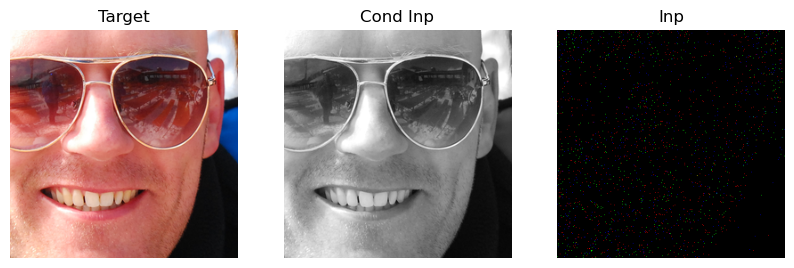

In [8]:
channels = 3
img = dataset[5000000000]
plt.figure(figsize= (10, 10))
plt.subplot(1, 3, 1)
plt.imshow(preprocess(img[:channels]))
plt.title('Target')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(preprocess(img[channels:channels + 1]), vmin = 0, vmax = 1, cmap= 'gray')
plt.title('Cond Inp')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(preprocess(img[channels + 1:channels  + 1 + 3]), vmin = 0, vmax = 255)
plt.title('Inp')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

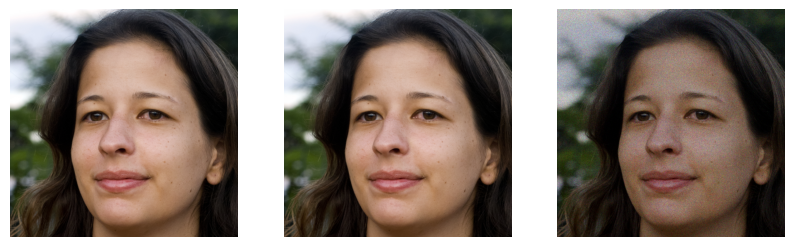

In [139]:
ffhq_path = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/ffhq/'
dataset = DataFolder(ffhq_path, minPSNR = 10, maxPSNR= 20, virtSize= 1)
dataTestGT, dataTestTarget, dataTest = dataset[0]

plt.figure(figsize= (10, 10))
plt.subplot(1, 3, 1)
plt.imshow(preprocess(dataTestGT))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(preprocess(dataTestTarget))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(preprocess(dataTest))
plt.axis('off')


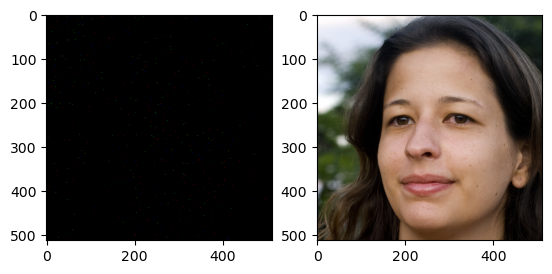

In [142]:
from PSNRSample import PSNRSample
psnr = PSNRSample(minPSNR= -40, maxPSNR= -30)
dataTest = psnr.sample(dataTestGT, 0.8)
testGT = dataTestGT/dataTestGT.mean()
cond_test = testGT 
plt.subplot(1, 2, 1)
plt.imshow(preprocess(dataTest))
plt.subplot(1, 2, 2)
plt.imshow(preprocess(cond_test))

In [126]:
from torchvision.transforms import Grayscale
convert = Grayscale()
cond_inp = convert(dataTestGT)
cond_inp = torch.from_numpy(np.array(cond_inp)).to(torch.float)
cond_inp = (cond_inp / (cond_inp.mean()+1e-8))
stats(cond_inp)


Min: 0.0
Max: 2.131112813949585
Mean: 1.0
Sum: 262144.0



torch.Size([3, 512, 512])
torch.Size([1, 1, 512, 512])
torch.Size([3, 512, 512])
input shape : torch.Size([1, 4, 512, 512]), model input shape : torch.Size([1, 1, 4, 512, 512])
tensor(255.) tensor(0.) tensor(83.5083) 255.0 114.0
inp shape : torch.Size([3, 512, 512])
out shape : torch.Size([1, 3, 512, 512])
gt shape : torch.Size([3, 512, 512])


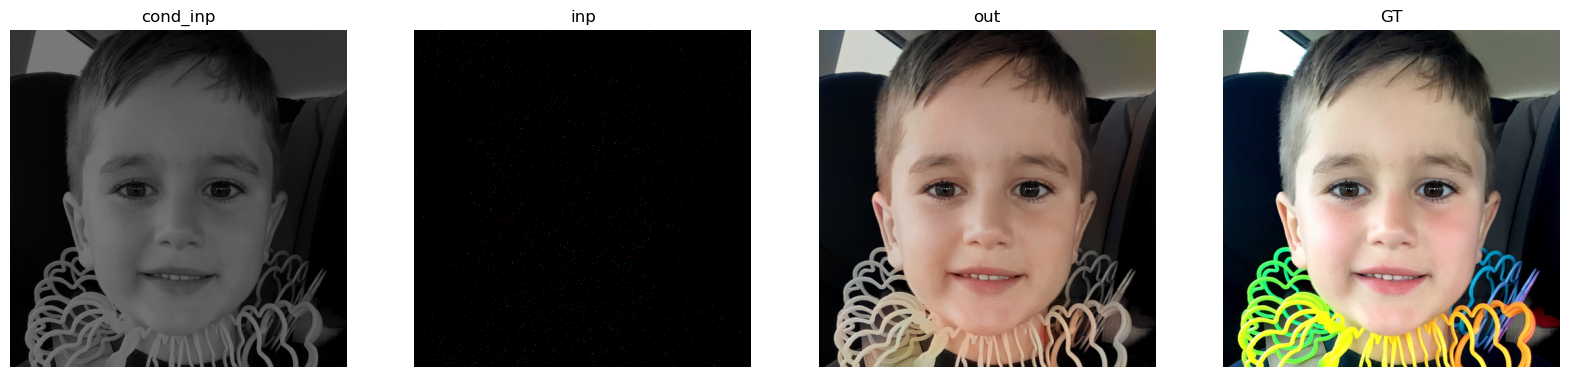

In [127]:
cond_input = torch.from_numpy(np.expand_dims(cond_inp, axis = 0))
# cond_input = torch.from_numpy(np.zeros_like(cond_input))
for inp, cinp, gt in zip(dataTest[None], cond_input[None], dataTestGT[None]): 
    print(inp.shape) 
    print(cinp.shape) 
    print(gt.shape) 

    inpT = inp.to(device) 
    cond_inpT = cinp.to(device)
    inpT = torch.cat([cond_inpT, inpT[None]], dim = 1).to(device)
    print(f'input shape : {inpT.shape}, model input shape : {inpT[None].shape}')
    out = torch.exp(model(inpT).detach().cpu())
    out = inp.sum() * out / out.sum() 
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))

    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    inp = inp/inp.max()
    out = out/out.max()
    gt = gt/gt.max()

    
    print(f'inp shape : {inp.shape}')
    print(f'out shape : {out.shape}')
    print(f'gt shape : {gt.shape}')

    cond_vmax = np.percentile(cond_inp,99.9)
    plt.figure(figsize=(20,20))
    plt.subplot(1, 4, 1)
    plt.imshow(preprocess(cond_inp) ,vmin = 0, vmax = cond_vmax, cmap = 'gray')
    plt.title('cond_inp')
    plt.axis('off')

    vmax = np.percentile(gt,99.9)
    plt.subplot(1, 4, 2)
    plt.imshow(preprocess(inp),vmin = 0, vmax = vmax)
    plt.title('inp')
    # plt.show()
    plt.axis('off')
    vmax = np.percentile(gt,99.9)
    plt.subplot(1, 4, 3)
    plt.imshow(preprocess(out[0]),vmin = 0,vmax = vmax)
    plt.title('out')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(preprocess(gt),vmin = 0,vmax = vmax)
    plt.title('GT')
    plt.axis('off')
    plt.show()
    


cond_input shape torch.Size([1, 1, 512, 512])
cond_img shape torch.Size([1, 1, 512, 512])
input_img shape torch.Size([1, 4, 512, 512])
input_img shape torch.float32
cond_input shape : torch.Size([1, 1, 512, 512])
photons shape: torch.Size([1, 3, 512, 512])



torch.Size([1, 3, 512, 512])

Max : 3.2950611057458445e-06
Min : 2.3610839505749937e-08
Mean : 1.271565793103946e-06
Sum : 1.0


Max : 0.0
Min : 0.0
Mean : 0.0
Sum : 0.0

torch.Size([1, 3, 512, 512])
cond_input shape : torch.Size([1, 1, 512, 512])
photons shape: torch.Size([1, 3, 512, 512])



torch.Size([1, 3, 512, 512])

Max : 3.2953807931335177e-06
Min : 2.361172057874228e-08
Mean : 1.271565793103946e-06
Sum : 1.0


Max : 1.0
Min : 0.0
Mean : 1.271565793103946e-06
Sum : 1.0

torch.Size([1, 3, 512, 512])
cond_input shape : torch.Size([1, 1, 512, 512])
photons shape: torch.Size([1, 3, 512, 512])



torch.Size([1, 3, 512, 512])

Max : 3.286433866378502e-06
Min : 2.3604949106470485e-08
Mean : 1.2715656794171082e-06
Sum : 0.99999988

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 512, 512])

Max : 3.738541863640421e-06
Min : 5.377278178286815e-09
Mean : 1.2715656794171082e-06
Sum : 0.9999999403953552


Max : 6.0
Min : 0.0
Mean : 0.18492762744426727
Sum : 145433.0

torch.Size([1, 3, 512, 512])
cond_input shape : torch.Size([1, 1, 512, 512])
photons shape: torch.Size([1, 3, 512, 512])



torch.Size([1, 3, 512, 512])

Max : 3.748461040231632e-06
Min : 5.207451803102003e-09
Mean : 1.271565793103946e-06
Sum : 1.0


Max : 6.0
Min : 0.0
Mean : 0.19397100806236267
Sum : 152545.0

torch.Size([1, 3, 512, 512])
(1, 3, 512, 512)


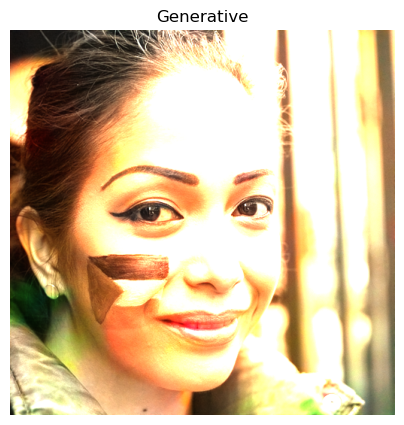

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


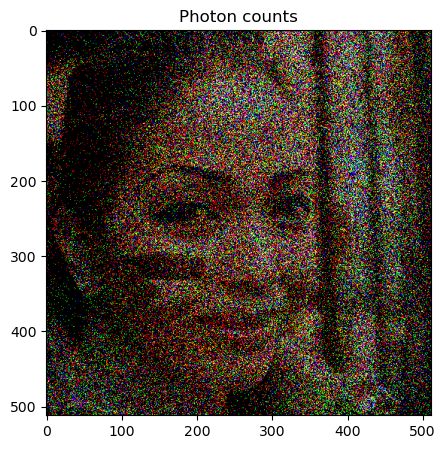

_______________________________________ 199
time (s): 10.156050682067871 time per image (s) 10.156050682067871


In [50]:
import matplotlib.image as mpimg
import time
import numpy as np

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 3
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 512
pixels_y = 512

inp_img =  torch.zeros(batch_size ,channels, pixels_y, pixels_x)
# inp_img = test.permute(2, 0, 1)[None]
# masks2 = inpainting(imgsize = 512, masksize = 500)
# mask = masks2.generate_mask().numpy()
cond_input = torch.from_numpy(np.expand_dims(cond_inp, axis = 0))
print(f'cond_input shape {cond_input.shape}')

cond_img = cond_input
print(f'cond_img shape {cond_img.shape}')

# cond_img = torch.zeros_like(cond_img)
input_img = torch.cat((cond_img, inp_img), 1).to(device)
print(f'input_img shape {input_img.shape}')
print(f'input_img shape {input_img.dtype}')


for i in range(1):
    

    startTime = time.time()
    
    # sampling the image(s)
    denoised, photons, stack, iterations = sample_image(input_img,
                                                        model, 
                                                        beta = 0.05,
                                                        save_every_n = 10,
                                                        max_psnr = 15,
                                                        max_its = 200,
                                                        channels = 3)

    
    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
#         print(iterations)
            # print(denoised.shape)
            # plt.figure(figsize = (5,5))
            # plt.imshow(denoised[j].transpose(1, 2, 0), cmap='inferno', vmin = 0,
            #            vmax = np.percentile(denoised[j],99.99))
            # plt.title('Generative')
            # plt.axis('off')
            # plt.show()
            
            # plt.figure(figsize = (5,5))
            # plt.imshow(photons[j,0], cmap='inferno', vmin = 0,
            #            vmax = np.percentile(photons[j],99.99))
            # plt.title('Photon counts')
            # plt.show()
            denoised/=denoised.mean()
            print(denoised.shape)
            plt.figure(figsize = (5,5))
            plt.imshow(denoised[0].transpose(1, 2, 0), vmin = 0,
                       vmax = np.percentile(denoised[0],99.99))
            plt.title('Generative')
            plt.axis('off')
            plt.show()
            
            plt.figure(figsize = (5,5))
            plt.imshow(photons[0].transpose(1, 2, 0)/photons[0].transpose(1, 2, 0).mean(), vmin = 0,
                       vmax = np.percentile(photons[j],99.99))
            plt.title('Photon counts')
            plt.show()
            
            
    
    print('_______________________________________', iterations)
    
    
    
    
    endTime = time.time()
    elapsedTime = endTime - startTime
    print ('time (s):', elapsedTime, 'time per image (s)', elapsedTime/denoised.shape[0])
   